In [20]:
import sys
from pathlib import Path

# Agregar el directorio raíz del proyecto al path
root_dir = Path().resolve().parents[1]
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

import numpy as np

from src.utils.fonts_processor import load_fonts, get_char_labels
from src.utils.data_analysis import (
    plot_training_loss,
    plot_reconstruction,
    plot_interpolation
)
from src.models.autoencoders import Autoencoder
from src.models.components.optimizers import Adam

In [8]:
# Configuración
LEARNING_RATE = 0.00082
EPOCHS = 9000
LATENT_DIM = 2
INPUT_DIM = 35  # 7x5

# Cargar datos
X_train = load_fonts()
char_labels = get_char_labels()

print(f"Datos cargados: {len(X_train)} patrones de dimensión {INPUT_DIM}")
print(f"Primeros caracteres: {char_labels[:5]}")

Datos cargados: 32 patrones de dimensión 35
Primeros caracteres: ['`', 'a', 'b', 'c', 'd']


In [11]:
# Crear autoencoder usando solo MLP
from src.models.components.mlp import MLP
from src.models.components.layers import Dense
from src.models.components.activation import Tanh, Sigmoid
from src.models.components.loss import bce, bce_prime

# Arquitectura del autoencoder:
# Encoder: 35 -> 16 -> 2 (espacio latente)
# Decoder: 2 -> 16 -> 35

layers = [
    # Encoder
    Dense(INPUT_DIM, 16),
    Tanh(),
    Dense(16, LATENT_DIM),
    Tanh(),
    # Decoder
    Dense(LATENT_DIM, 16),
    Tanh(),
    Dense(16, INPUT_DIM),
    Sigmoid()
]

optimizer = Adam(learning_rate=LEARNING_RATE)
autoencoder = MLP(
    layers=layers,
    loss=bce,
    loss_prime=bce_prime,
    optimizer=optimizer
)

print("Autoencoder creado con arquitectura: 35 -> 16 -> 2 -> 16 -> 35")

Autoencoder creado con arquitectura: 35 -> 16 -> 2 -> 16 -> 35


In [12]:
# Entrenar el autoencoder
X_train_reshaped = np.array([x.reshape(-1, 1) for x in X_train])
y_train = X_train_reshaped.copy()  # El target es la misma entrada (reconstrucción)

print("Iniciando entrenamiento...")
history = autoencoder.train(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=1, verbose=True)
print("Entrenamiento completado!")

Iniciando entrenamiento...
Época 100/9000 - Pérdida: 0.487301
Época 100/9000 - Pérdida: 0.487301
Época 200/9000 - Pérdida: 0.447979
Época 200/9000 - Pérdida: 0.447979
Época 300/9000 - Pérdida: 0.414584
Época 300/9000 - Pérdida: 0.414584
Época 400/9000 - Pérdida: 0.389172
Época 400/9000 - Pérdida: 0.389172
Época 500/9000 - Pérdida: 0.366501
Época 500/9000 - Pérdida: 0.366501
Época 600/9000 - Pérdida: 0.340453
Época 600/9000 - Pérdida: 0.340453
Época 700/9000 - Pérdida: 0.316456
Época 700/9000 - Pérdida: 0.316456
Época 800/9000 - Pérdida: 0.295911
Época 800/9000 - Pérdida: 0.295911
Época 900/9000 - Pérdida: 0.276070
Época 900/9000 - Pérdida: 0.276070
Época 1000/9000 - Pérdida: 0.261732
Época 1000/9000 - Pérdida: 0.261732
Época 1100/9000 - Pérdida: 0.249347
Época 1100/9000 - Pérdida: 0.249347
Época 1200/9000 - Pérdida: 0.237352
Época 1200/9000 - Pérdida: 0.237352
Época 1300/9000 - Pérdida: 0.230850
Época 1300/9000 - Pérdida: 0.230850
Época 1400/9000 - Pérdida: 0.221496
Época 1400/9000 - P

In [16]:
# Visualizar la pérdida durante el entrenamiento
plot_training_loss(history)

In [23]:
import matplotlib.pyplot as plt
def plot_latent_space(latent_representations, char_labels, title="Representación de 32 Patrones en el Espacio Latente (Z1 vs Z2)"):
    plt.figure(figsize=(12, 10))
    plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c='b', alpha=0.7)
    
    for i, label in enumerate(char_labels):
        plt.annotate(
            label, 
            (latent_representations[i, 0], latent_representations[i, 1]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )

    plt.title(title)
    plt.xlabel("Z1")
    plt.ylabel("Z2")
    plt.grid(True)


C:\Users\juani\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\juani\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\juani\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


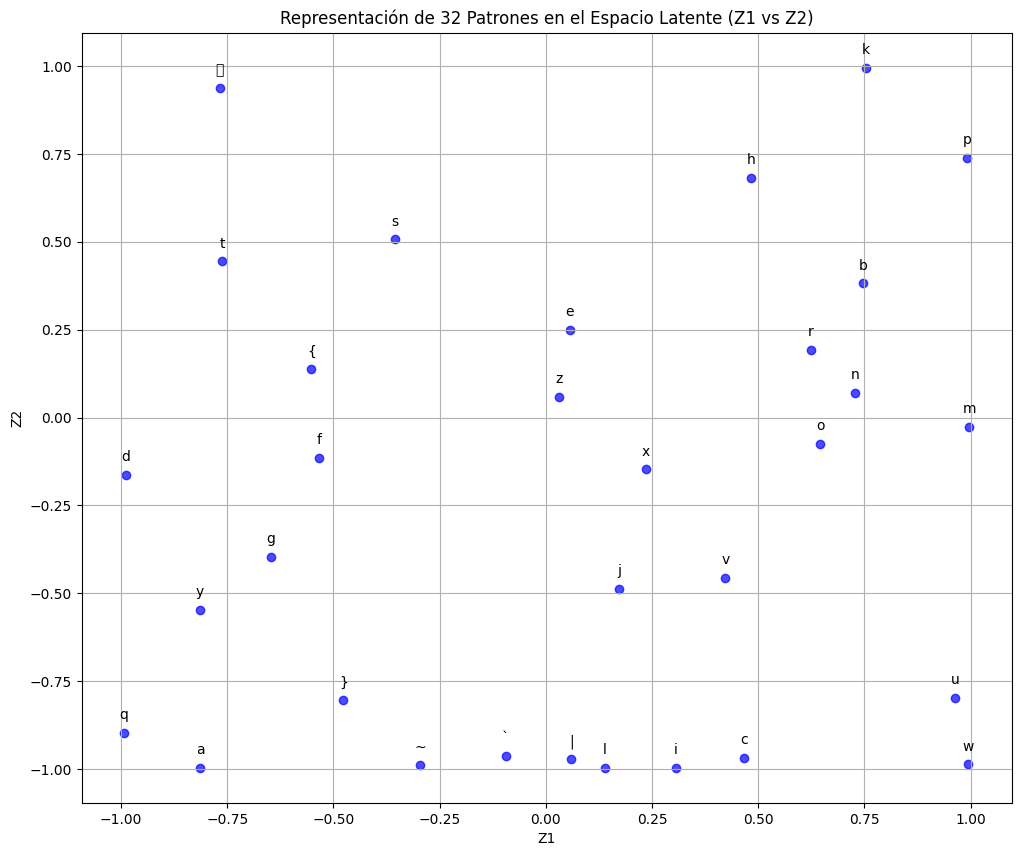

In [24]:
# Función para extraer el espacio latente (encoder)
def encode(autoencoder, x):
    """Pasa por las capas del encoder hasta el espacio latente"""
    output = x
    # Las primeras 4 capas son el encoder (Dense, Tanh, Dense, Tanh)
    for layer in autoencoder.layers[:4]:
        output = layer.forward(output)
    return output

# Extraer representaciones latentes
latent_representations = np.array([
    encode(autoencoder, x.reshape(-1, 1)).flatten() for x in X_train
])

# Visualizar espacio latente
plot_latent_space(latent_representations, char_labels)

In [27]:
# Dimensiones constantes para la visualización
HEIGHT = 7
WIDTH = 5

In [28]:
def plot_reconstruction(X_original, X_prime, char_label, title="Caracter En Reconstruccion"):
    X_prime_rounded = (X_prime.flatten() > 0.5).astype(float)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    axes[0].imshow(X_original.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
    axes[0].set_title(f"Original ('{char_label}')")
    axes[0].axis('off')

    axes[1].imshow(X_prime_rounded.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest') 
    axes[1].set_title(f"Reconstrucción")
    axes[1].axis('off')
    
    plt.suptitle("Demostración de la Capacidad de Reconstrucción")
    plt.title(title)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    
    # Sanitizar nombre de archivo para Windows
    safe_char_label = "".join(c for c in char_label if c.isalnum() or c in (' ', '-', '_'))
    if not safe_char_label:
        safe_char_label = f"char_{ord(char_label)}"
    


C:\Users\juani\AppData\Local\Temp\ipykernel_20664\3262629562.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(6, 3))
C:\Users\juani\AppData\Local\Temp\ipykernel_20664\3262629562.py:16: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
C:\Users\juani\AppData\Local\Temp\ipykernel_20664\3262629562.py:16: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.9])


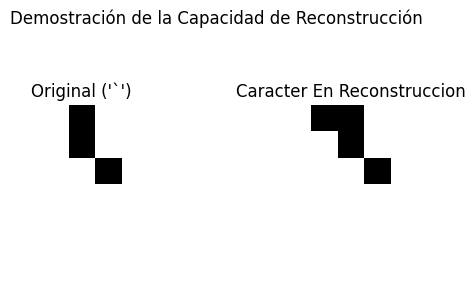

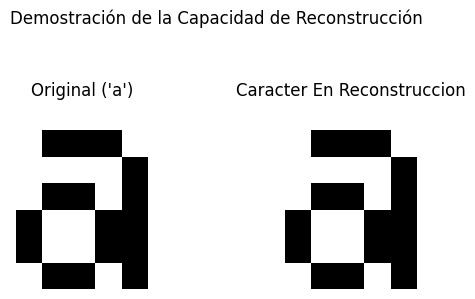

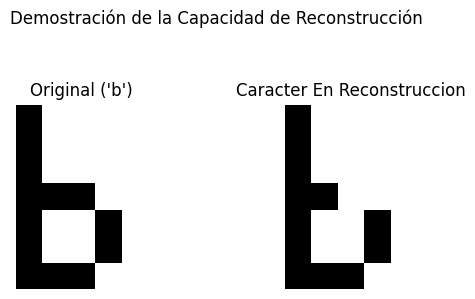

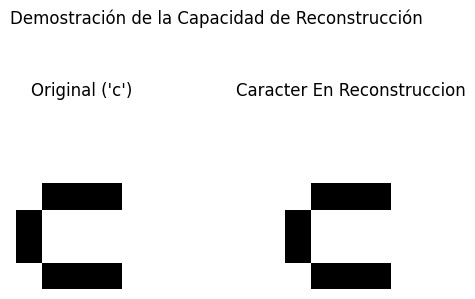

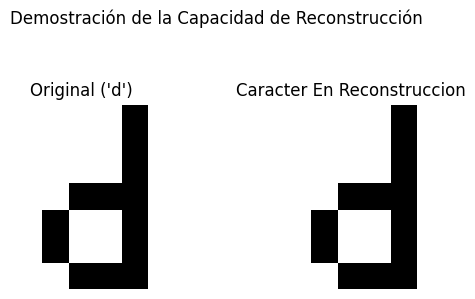

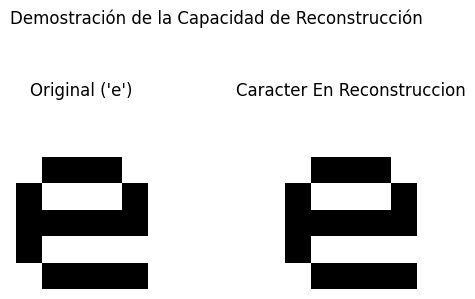

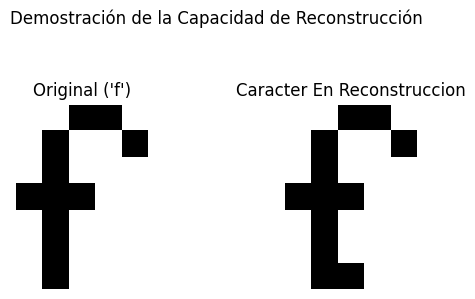

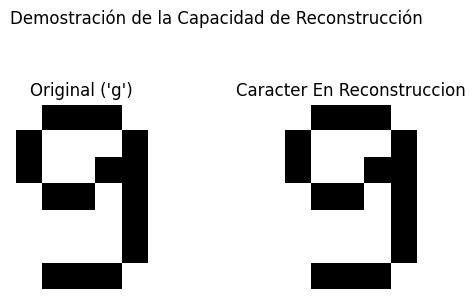

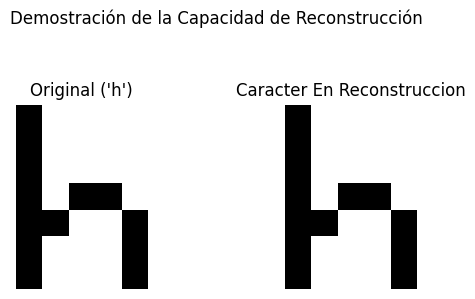

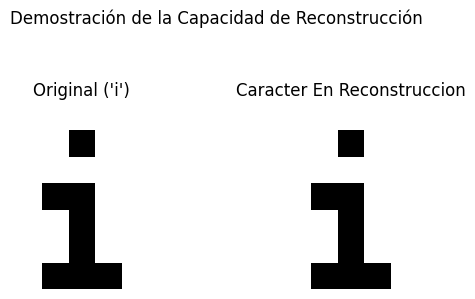

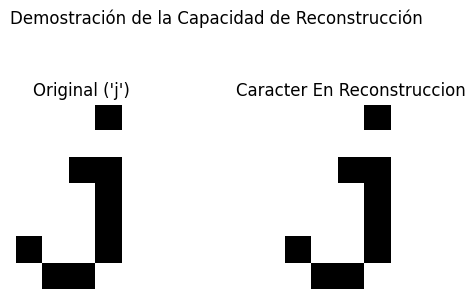

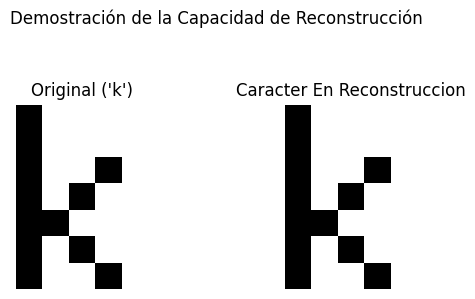

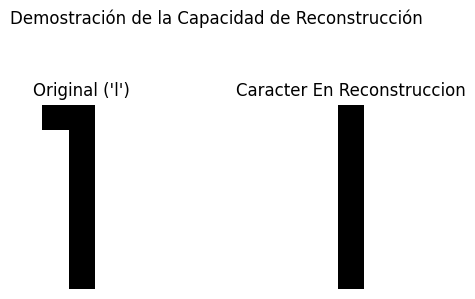

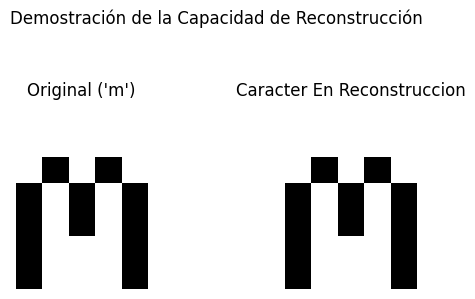

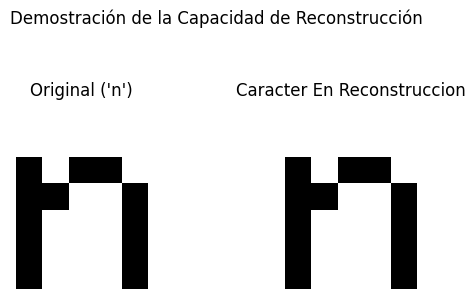

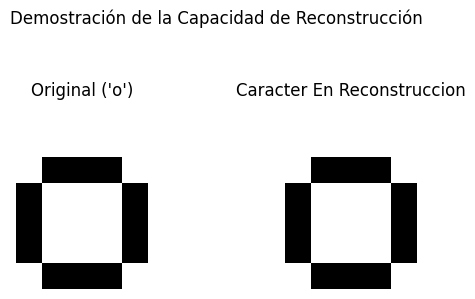

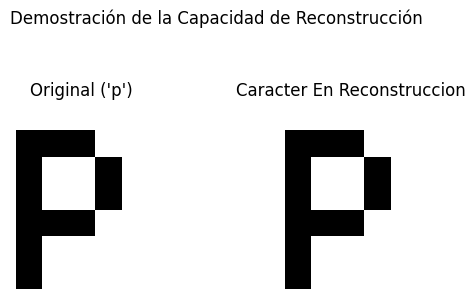

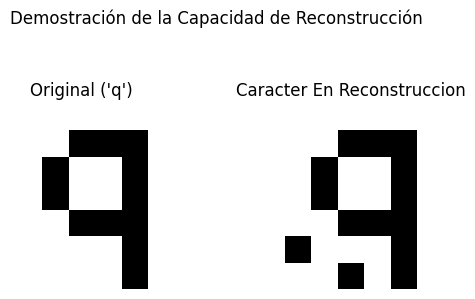

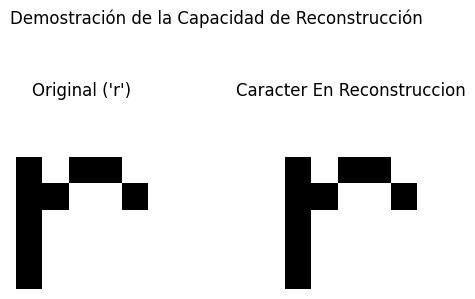

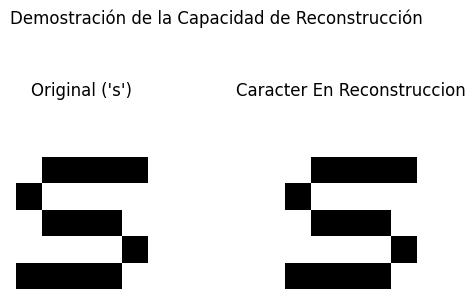

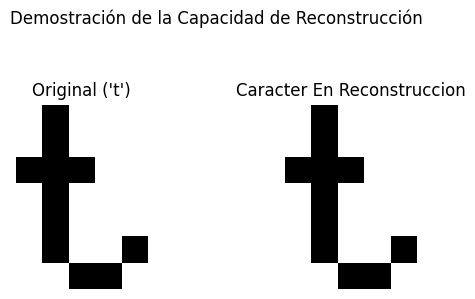

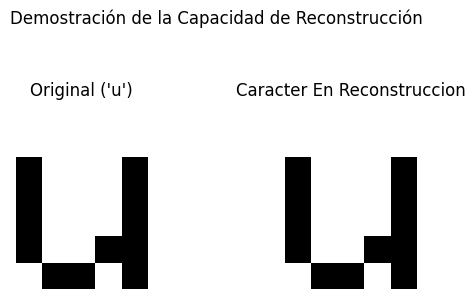

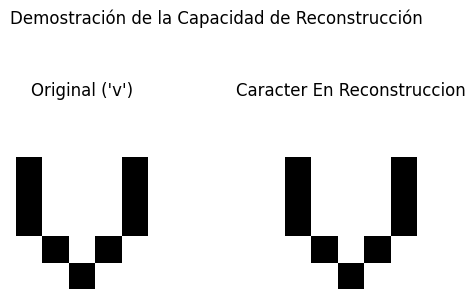

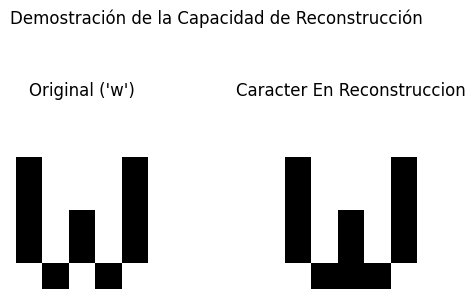

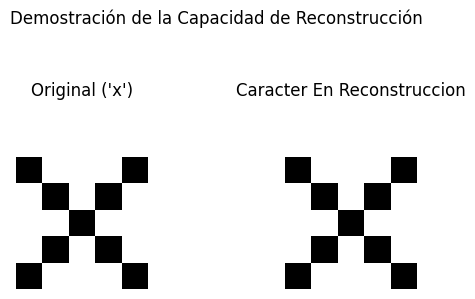

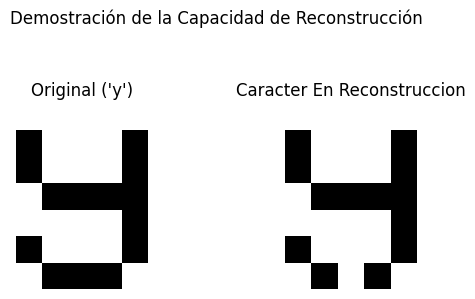

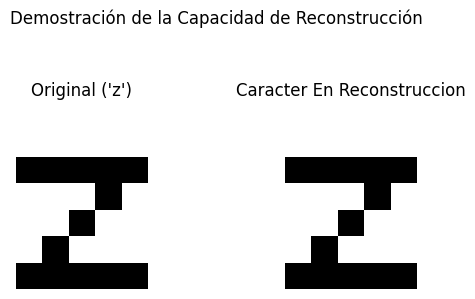

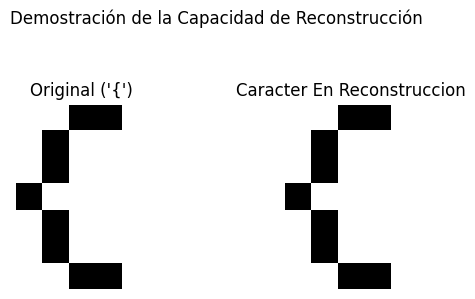

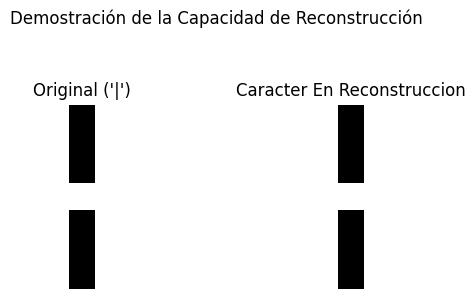

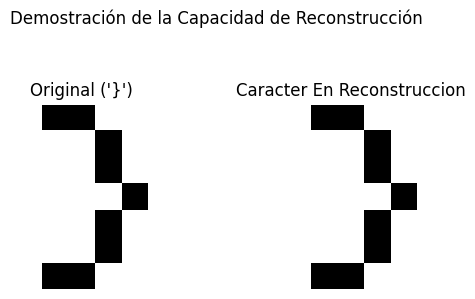

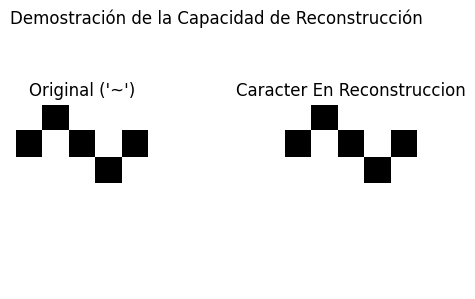

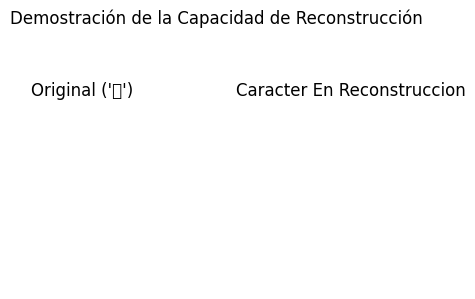

In [29]:
# Demo de reconstrucción para todos los caracteres
for i in range(len(X_train)):
    X_original = X_train[i]
    X_reconstructed = autoencoder.forward(X_original.reshape(-1, 1))
    
    plot_reconstruction(
        X_original,
        X_reconstructed.flatten(),
        char_labels[i]
    )

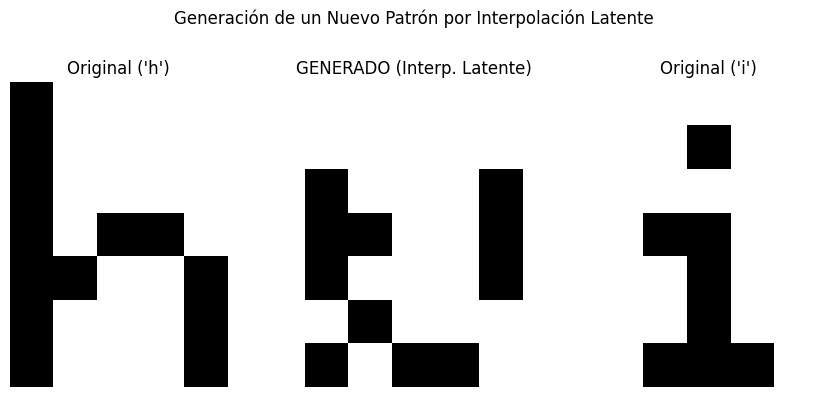

In [31]:
# Función para decodificar desde el espacio latente
def decode(autoencoder, z):
    """Pasa por las capas del decoder desde el espacio latente"""
    output = z
    # Las últimas 4 capas son el decoder (Dense, Tanh, Dense, Sigmoid)
    for layer in autoencoder.layers[4:]:
        output = layer.forward(output)
    return output

# Interpolación entre dos caracteres
char1_idx = 8  # 'h'
char2_idx = 9  # 'i'

# Obtener representaciones latentes
Z1 = encode(autoencoder, X_train[char1_idx].reshape(-1, 1))
Z2 = encode(autoencoder, X_train[char2_idx].reshape(-1, 1))

# Interpolar en el espacio latente (punto medio)
Z_interp = Z1 * 0.5 + Z2 * 0.5

# Decodificar el punto interpolado
X_interp = decode(autoencoder, Z_interp)

# Visualizar
plot_interpolation(
    X_train[char1_idx],
    X_train[char2_idx],
    X_interp,
    char_labels[char1_idx],
    char_labels[char2_idx]
)

In [30]:
def plot_interpolation(X1_original, X2_original, X_interp_prime, char1_label, char2_label):
    X_interp_rounded = (X_interp_prime.flatten() > 0.5).astype(float)
    
    fig, axes = plt.subplots(1, 3, figsize=(9, 4))
    
    # Original 1
    axes[0].imshow(X1_original.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
    axes[0].set_title(f"Original ('{char1_label}')")
    axes[0].axis('off')

    # Interpolado (Generado)
    axes[1].imshow(X_interp_rounded.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
    axes[1].set_title(f"GENERADO (Interp. Latente)")
    axes[1].axis('off')

    # Original 2
    axes[2].imshow(X2_original.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
    axes[2].set_title(f"Original ('{char2_label}')")
    axes[2].axis('off')

    plt.suptitle("Generación de un Nuevo Patrón por Interpolación Latente")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Sanitizar nombres de archivo para Windows
    safe_char1 = "".join(c for c in char1_label if c.isalnum() or c in (' ', '-', '_'))
    safe_char2 = "".join(c for c in char2_label if c.isalnum() or c in (' ', '-', '_'))
    if not safe_char1:
        safe_char1 = f"char_{ord(char1_label)}"
    if not safe_char2:
        safe_char2 = f"char_{ord(char2_label)}"
    